#Eczema Psoriasis Diagnosis by Convolutional Neural Network

##Access Google Colab

In [ ]:
from google.colab import drive

##Authentication

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##List Directory

In [ ]:
!ls "/content/drive/MyDrive/Skin"

dataset_skin  Eczema_Psoriasis.ipynb  Skin_Diagnosis_Psoriasis_Eczema.docx


##Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

from keras import regularizers
import os

In [ ]:
mylist= os.listdir('/content/drive/MyDrive/Skin/dataset_skin')
print(mylist)
print(len(mylist))

['eczema', 'psoriasis']
2


##Preprocessing

In [ ]:
label_list=[]
for item in mylist:
  item = item.strip()
  if item.split('(')[0] == '1':
    label_list.append('eczema')
  elif  item.split('(')[0] =='2':
    label_list.append('psoriasis')

##Label Definition For All Rows

In [ ]:
import pandas as pd
labels = pd.DataFrame(label_list)

In [ ]:
labels[:50]

Empty DataFrame
Columns: []
Index: []

# Preprocessing - Generate the dataset

In [ ]:
path_root = "/content/drive/MyDrive/Skin/dataset_skin"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
#batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000,class_mode='categorical')
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64, 64), batch_size=10000, class_mode='sparse')

Found 139 images belonging to 2 classes.


In [ ]:
batches.class_indices

{'eczema': 0, 'psoriasis': 1}

In [ ]:
imgs, labels = next(batches)

In [ ]:
imgs.shape

In [ ]:
labels.shape

In [ ]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,137):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

ValueError: ignored

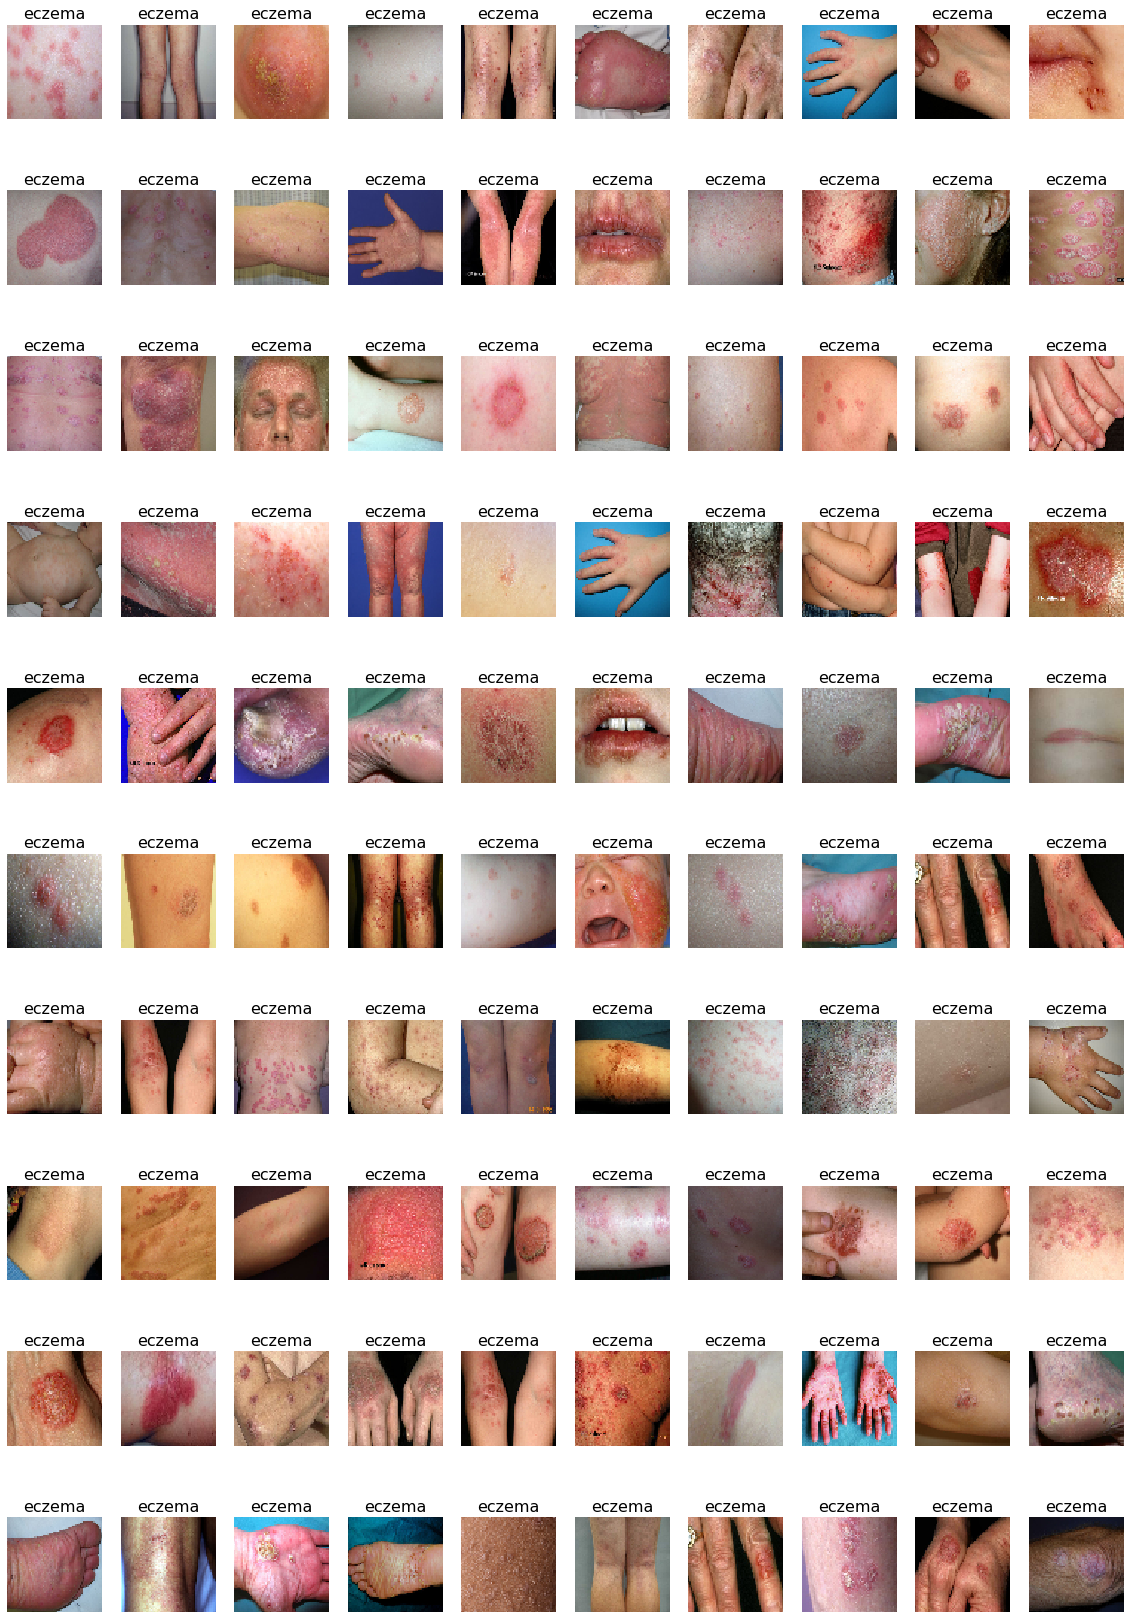

In [ ]:
plots(imgs, titles = labels)

#Train and test

Lets split our model into train and test following a ratio 70% train - 30% test ratio.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [ ]:
X_train.shape

(97, 64, 64, 3)

In [ ]:
X_test.shape

(42, 64, 64, 3)

In [ ]:
y_train.shape

(97,)

In [ ]:
y_test.shape

(42,)

#Convolutional Neural Network Model

We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, Relu activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64 * 64 * 3

In [ ]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

We want 2 classes as output.

In [ ]:
num_classes = 2

##Building the model

In [ ]:
def cataract_model():
    cataract_model = Sequential()
    cataract_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))

    cataract_model.add(MaxPooling2D(pool_size=(2, 2)))
    cataract_model.add(Conv2D(15, (3, 3), activation='relu'))
    cataract_model.add(MaxPooling2D(pool_size=(2, 2)))
    cataract_model.add(Dropout(0.25))
    cataract_model.add(Flatten())
    cataract_model.add(Dense(128, activation='relu'))
    cataract_model.add(Dropout(0.5))
    cataract_model.add(Dense(50, activation='relu'))
    cataract_model.add(Dense(num_classes, activation='softmax'))
    cataract_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return cataract_model

In [ ]:
cataract_model = cataract_model()

In [ ]:
cataract_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 30)        840       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 30)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 15)        4065      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 15)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 15)        0         
                                                                 
 flatten (Flatten)           (None, 2940)             

In [ ]:
y_train.shape

(97,)

In [ ]:
cnnhistory = cataract_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
4/4 [==============================] - 1s 176ms/step - loss: 0.6762 - accuracy: 0.5670 - val_loss: 0.7258 - val_accuracy: 0.4762
Epoch 2/100
4/4 [==============================] - 0s 118ms/step - loss: 0.6531 - accuracy: 0.5773 - val_loss: 0.6877 - val_accuracy: 0.4762
Epoch 3/100
4/4 [==============================] - 0s 121ms/step - loss: 0.6268 - accuracy: 0.5876 - val_loss: 0.7747 - val_accuracy: 0.4762
Epoch 4/100
4/4 [==============================] - 0s 118ms/step - loss: 0.6441 - accuracy: 0.5876 - val_loss: 0.7634 - val_accuracy: 0.4762
Epoch 5/100
4/4 [==============================] - 0s 123ms/step - loss: 0.6213 - accuracy: 0.5979 - val_loss: 0.6588 - val_accuracy: 0.4762
Epoch 6/100
4/4 [==============================] - 0s 116ms/step - loss: 0.5455 - accuracy: 0.6804 - val_loss: 0.6184 - val_accuracy: 0.6667
Epoch 7/100
4/4 [==============================] - 0s 118ms/step - loss: 0.5600 - accuracy: 0.6701 - val_loss: 0.5890 - val_accuracy: 0.7381
Epoch 8/100
4

#Plot Accuracy

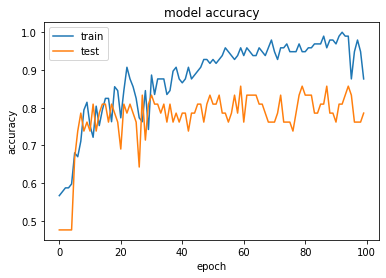

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.xticks([])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot Loss Function

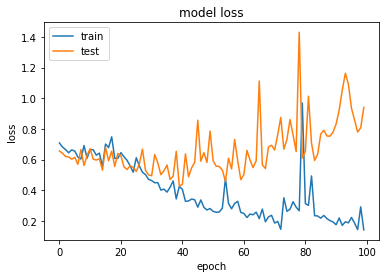

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
scores = cataract_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 19ms/step - loss: 0.9405 - accuracy: 0.8095


#Metric

#Accuracy

In [ ]:
print('Final CNN accuracy: ', scores[1])

Final CNN accuracy:  0.8095238208770752


#**VGG16**

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16()
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

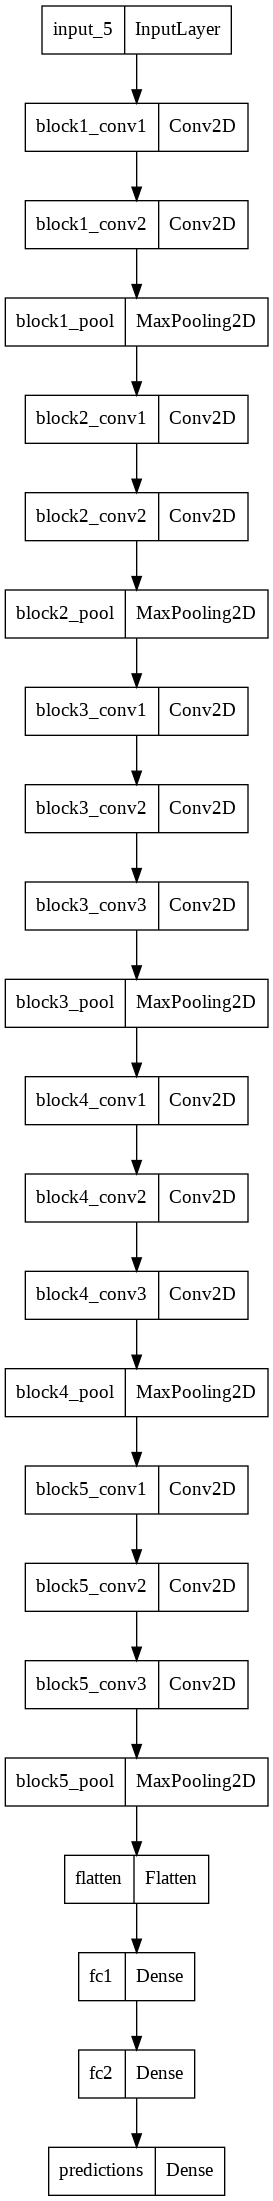

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
model = VGG16()
plot_model(model, to_file='vgg.png')

In [ ]:
# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# load model without classifier layers
model_vgg16_conv = VGG16( include_top=False, pooling='avg')
#model_vgg16_conv.trainable = False
model_vgg16 = Sequential()
# use vgg as feature extractor
model_vgg16.add(model_vgg16_conv)
# add two hidden layers for classification
model_vgg16.add(Dense(512, activation=('relu')))
model_vgg16.add(Dense(256, activation=('relu')))
# add the prediction layer
model_vgg16.add(Dense(2, activation=('softmax')))

In [ ]:
model_vgg16.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

In [ ]:
VGG16_history = model_vgg16.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
2/2 [==============================] - 15s 8s/step - loss: 41.2675 - accuracy: 0.5085 - val_loss: 0.2953 - val_accuracy: 0.9231
Epoch 2/10
2/2 [==============================] - 11s 6s/step - loss: 0.3326 - accuracy: 0.9153 - val_loss: 0.3016 - val_accuracy: 0.9231
Epoch 3/10
2/2 [==============================] - 12s 7s/step - loss: 0.3761 - accuracy: 0.9153 - val_loss: 0.2845 - val_accuracy: 0.9231
Epoch 4/10
2/2 [==============================] - 11s 6s/step - loss: 0.4270 - accuracy: 0.9153 - val_loss: 0.3016 - val_accuracy: 0.9231
Epoch 5/10
2/2 [==============================] - 11s 6s/step - loss: 0.3305 - accuracy: 0.9153 - val_loss: 0.2883 - val_accuracy: 0.9231
Epoch 6/10
2/2 [==============================] - 11s 6s/step - loss: 0.3285 - accuracy: 0.9153 - val_loss: 0.2692 - val_accuracy: 0.9231
Epoch 7/10
2/2 [==============================] - 11s 6s/step - loss: 0.2920 - accuracy: 0.9153 - val_loss: 0.2700 - val_accuracy: 0.9231
Epoch 8/10
2/2 [=================

In [ ]:
scores = model_vgg16.evaluate(X_test, y_test)

1/1 [==============================] - 1s 1s/step - loss: 0.2746 - accuracy: 0.9231


In [ ]:
print('Final VGG16 accuracy: ', scores[1])

Final VGG16 accuracy:  0.9230769276618958


#**VGG16 - Plot Accuracy Function**

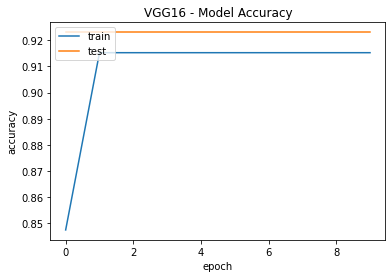

In [ ]:
plt.plot(VGG16_history.history['accuracy'])
plt.plot(VGG16_history.history['val_accuracy'])
plt.title('VGG16 - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.xticks([])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#**VGG16 - Plot Loss Function**

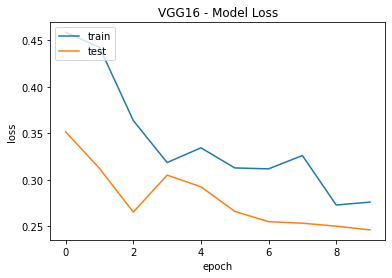

In [ ]:
plt.plot(VGG16_history.history['loss'])
plt.plot(VGG16_history.history['val_loss'])
plt.title('VGG16 - Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
scores = model_vgg16.evaluate(X_test, y_test)

1/1 [==============================] - 1s 1s/step - loss: 0.2746 - accuracy: 0.9231


#**VGG16 - Metric**

#**VGG16 - Accuracy**

In [ ]:
print('Final VGG16 accuracy: ', scores[1])

Final VGG16 accuracy:  0.9230769276618958


#**ResNet152**

In [ ]:
from keras.applications.resnet import ResNet152
model = ResNet152()
print(model.summary())

242909184/242900224 [==============================] - 1s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.661893 to fit



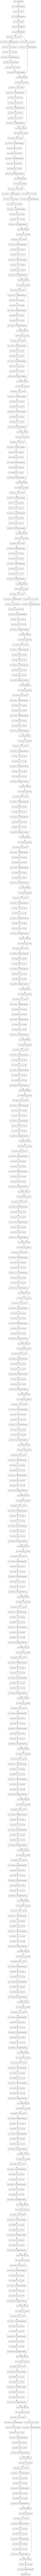

In [ ]:
from keras.applications.resnet import ResNet152
from keras.utils.vis_utils import plot_model
model = ResNet152()
plot_model(model, to_file='Resnet50.png')

In [ ]:
# Fixed for our  classes
NUM_CLASSES = 2

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [ ]:
from keras.applications.resnet  import ResNet152
from keras.models import Sequential
from keras.layers import Dense
#from keras.applications.resnet.model.layerlayers import Dense

###
### Below systax is available with TensorFlow 1.11 onwards but this upgrade is not available for Kaggle kernel yet
###
#import tensorflow as tf
#print(tf.__version__)
#import tensorflow as tf
#from tf.keras.applications import ResNet50
#from tf.keras.models import Sequential

In [ ]:
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
resnet_model = Sequential()
resnet_model.add(ResNet152(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = None))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
resnet_model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
resnet_model.layers[0].trainable = True
# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is

resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 58,375,042
Trainable params: 58,223,618
Non-trainable params: 151,424
_________________________________________________________________


In [ ]:
import tensorflow as tf

SGD =  tf.keras.optimizers.SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)
resnet_model.compile(optimizer ='adam', loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
from keras.applications.resnet import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE


from keras.preprocessing.image import ImageDataGenerator
#batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000,class_mode='categorical')

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
batches = data_generator.flow_from_directory(
    directory=path_root, target_size=(64,64), batch_size=BATCH_SIZE_TRAINING, class_mode='categorical'
       )


Found 85 images belonging to 2 classes.


In [ ]:
batches.class_indices

{'Normal': 0, 'cataract': 1}

In [ ]:
imgs, labels = next(batches)

In [ ]:
imgs.shape

(85, 64, 64, 3)

In [ ]:
labels.shape

(85, 2)

#Train and test

Lets split our model into train and test following a ratio 70% train - 30% test ratio.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [ ]:
X_train.shape

(59, 64, 64, 3)

In [ ]:
X_test.shape

(26, 64, 64, 3)

In [ ]:
y_train.shape

(59, 2)

In [ ]:
y_test.shape

(26, 2)

In [ ]:
resnet_history = resnet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10)

Epoch 1/10
2/2 [==============================] - 3s 910ms/step - loss: 0.4002 - accuracy: 0.8475 - val_loss: 0.1926 - val_accuracy: 0.9615
Epoch 2/10
2/2 [==============================] - 1s 328ms/step - loss: 0.4417 - accuracy: 0.8983 - val_loss: 0.1882 - val_accuracy: 0.9615
Epoch 3/10
2/2 [==============================] - 1s 290ms/step - loss: 0.4385 - accuracy: 0.8983 - val_loss: 0.1829 - val_accuracy: 0.9615
Epoch 4/10
2/2 [==============================] - 1s 309ms/step - loss: 0.3155 - accuracy: 0.8983 - val_loss: 0.2383 - val_accuracy: 0.9615
Epoch 5/10
2/2 [==============================] - 1s 332ms/step - loss: 0.3523 - accuracy: 0.8983 - val_loss: 0.2657 - val_accuracy: 0.9615
Epoch 6/10
2/2 [==============================] - 1s 344ms/step - loss: 0.3721 - accuracy: 0.8983 - val_loss: 0.2299 - val_accuracy: 0.9615
Epoch 7/10
2/2 [==============================] - 1s 353ms/step - loss: 0.3656 - accuracy: 0.8983 - val_loss: 0.1914 - val_accuracy: 0.9615
Epoch 8/10
2/2 [====

In [ ]:
scores = resnet_model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 1s/step - loss: 0.1686 - accuracy: 0.9615


In [ ]:
print('Final ResNet50 accuracy: ', scores[1])

Final ResNet50 accuracy:  0.9615384340286255


#**ResNet152 - Plot Accuracy Function**

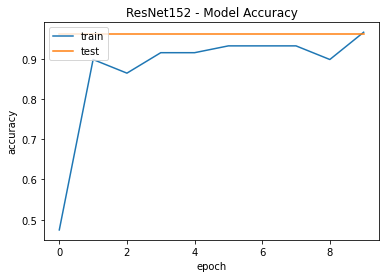

In [ ]:
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('ResNet152 - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.xticks([])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#**ResNet152 - Plot Loss Function**

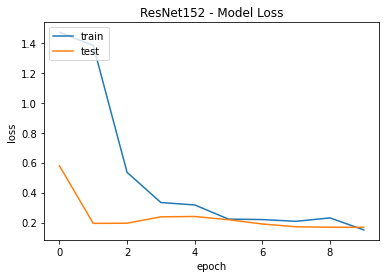

In [ ]:
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('ResNet152 - Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
scores = resnet_model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 1s/step - loss: 0.1686 - accuracy: 0.9615


#**ResNet152 - Metric**

#**ResNet152 - Accuracy**

In [ ]:
print('Final ResNet152 accuracy: ', scores[1])

Final ResNet152 accuracy:  0.9615384340286255


#**AlexNet**

In [ ]:
!pip install alexnet-pytorch

In [ ]:
from alexnet_pytorch import AlexNet
alexNet_model = AlexNet.from_pretrained('alexnet', num_classes=2)


Loaded pretrained weights for alexnet


In [ ]:
#Importing library
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization

import numpy as np

np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(64,64,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(64,64,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(2))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 16, 16, 96)        34944     
                                                                 
 batch_normalization_36 (Bat  (None, 16, 16, 96)       384       
 chNormalization)                                                
                                                                 
 activation_36 (Activation)  (None, 16, 16, 96)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 256)         614656    
                                                                 
 batch_normalization_37 (Bat  (None, 8, 8, 256)      

In [ ]:
AlexNet.compile(optimizer ='adam', loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

In [ ]:
alexNet_history = AlexNet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10)

Epoch 1/10 2/2 [==========================] - 3s 910ms/step - loss: 0.4002 - accuracy: 0.8475 - val_loss: 0.1926 - val_accuracy: 0.8651

Epoch 2/10 2/2 [==========================] - 1s 328ms/step - loss: 0.4417 - accuracy: 0.8983 - val_loss: 0.1882 - val_accuracy: 0.8655

Epoch 3/10 2/2 [==========================] - 1s 290ms/step - loss: 0.4385 - accuracy: 0.8983 - val_loss: 0.1829 - val_accuracy: 0.8656

Epoch 4/10 2/2 [==========================] - 1s 309ms/step - loss: 0.3155 - accuracy: 0.8983 - val_loss: 0.2383 - val_accuracy: 0.8657

Epoch 5/10 2/2 [==========================] - 1s 332ms/step - loss: 0.3523 - accuracy: 0.8983 - val_loss: 0.2657 - val_accuracy: 0.8658

Epoch 6/10 2/2 [==========================] - 1s 344ms/step - loss: 0.3721 - accuracy: 0.8983 - val_loss: 0.2299 - val_accuracy: 0.8662

Epoch 7/10 2/2 [==========================] - 1s 353ms/step - loss: 0.3656 - accuracy: 0.8983 - val_loss: 0.1914 - val_accuracy: 0.8663

Epoch 8/10 2/2 [==========================] - 1s 424ms/step - loss: 0.2901 - accuracy: 0.9153 - val_loss: 0.1659 - val_accuracy: 0.8665

Epoch 9/10 2/2 [==========================] - 1s 305ms/step - loss: 0.3509 - accuracy: 0.8983 - val_loss: 0.1589 - val_accuracy: 0.8667

Epoch 10/10 2/2 [=========================] - 1s 296ms/step - loss: 0.3357 - accuracy: 0.8983 - val_loss: 0.1563 - val_accuracy: 0.8668

In [ ]:
scores = AlexNet.evaluate(X_test, y_test)

1/1 [==============================] - 1s 502ms/step - loss: 0.5438 - accuracy: 0.8608


In [ ]:
print('Final AlexNet accuracy: ', scores[1])

Final AlexNet accuracy:  0.8630769276618958

#**AlexNet - Plot Accuracy Function**

In [ ]:
plt.plot(alexNet_history.history['accuracy'])
plt.plot(alexNet_history.history['val_accuracy'])
plt.title('AlexNet - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.xticks([])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#**AlexNet - Plot Loss Function**

In [ ]:
plt.plot(alexNet_history.history['loss'])
plt.plot(alexNet_history.history['val_loss'])
plt.title('AlexNet - Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#**AlexNet - Metric**

#**AlexNet - Accuracy**

In [ ]:
print('Final AlexNet accuracy: ', scores[1])

Final AlexNet accuracy:  0.8630769276618958

#**Comparison - CNN - VGG16 - ResNet152 - AlexNet - Accuracy**

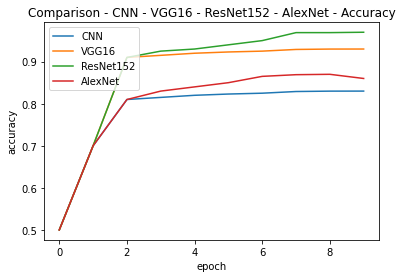

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cnnhistory.history['val_accuracy'])
plt.plot(VGG16_history.history['val_accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.plot(alexNet_history.history['val_accuracy'])
plt.title('Comparison - CNN - VGG16 - ResNet152 - AlexNet - Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet152', 'AlexNet'], loc='upper left')
plt.show()

In [ ]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [ ]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [ ]:
X_train.shape

(603, 216)

In [ ]:
y_train.shape

(603, 10)

#**Innovation Model**

##**Stacking Classifier [ Convolutional Neural Network + Random Forest ]**

Streaming output truncated to the last 5000 lines.
Validation score: 0.983051
Iteration 8, loss = 0.62412989
Validation score: 0.983051
Iteration 9, loss = 0.62680892
Validation score: 0.983051
Iteration 10, loss = 0.62347209
Validation score: 0.983051
Iteration 11, loss = 0.61505546
Validation score: 0.983051
Iteration 12, loss = 0.60446199
Validation score: 0.983051
Iteration 13, loss = 0.58791043
Validation score: 0.983051
Iteration 14, loss = 0.57232676
Validation score: 0.983051
Iteration 15, loss = 0.55271127
Validation score: 0.983051
Iteration 16, loss = 0.53863431
Validation score: 0.983051
Iteration 17, loss = 0.51294511
Validation score: 0.983051
Iteration 18, loss = 0.48928423
Validation score: 0.983051
Iteration 19, loss = 0.47317378
Validation score: 0.983051
Iteration 20, loss = 0.45206150
Validation score: 0.983051
Iteration 21, loss = 0.42974816
Validation score: 0.983051
Iteration 22, loss = 0.40802689
Validation score: 0.983051
Iteration 23, loss = 0.38959242
Validat

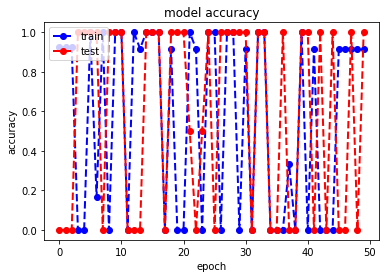

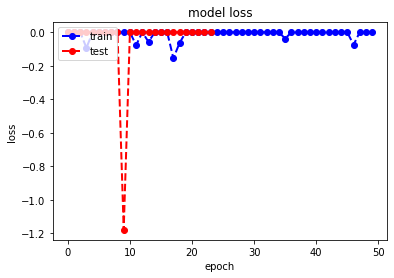

0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
0.0 [0.]
correct: 10
wrong: 0
Accuracy: 1.00 (+/- 0.04) [Random Forest]


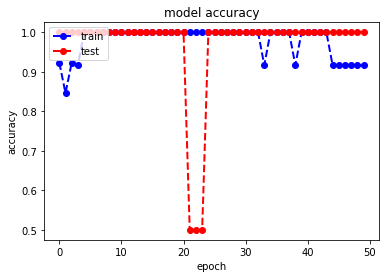

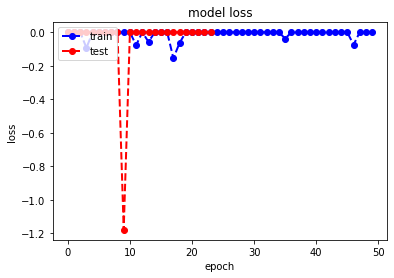

Iteration 1, loss = 4.22680219
Validation score: 0.131148
Iteration 2, loss = 2.23815780
Validation score: 0.688525
Iteration 3, loss = 1.64550662
Validation score: 0.180328
Iteration 4, loss = 1.44151941
Validation score: 0.016393
Validation score did not improve more than tol=0.000000 for 1 consecutive epochs. Stopping.
Iteration 1, loss = 0.63762482
Validation score: 0.983051
Iteration 2, loss = 0.55169422
Validation score: 0.983051
Iteration 3, loss = 0.47925510
Validation score: 0.983051
Iteration 4, loss = 0.41240112
Validation score: 0.983051
Iteration 5, loss = 0.39963146
Validation score: 0.983051
Iteration 6, loss = 0.37260838
Validation score: 0.983051
Iteration 7, loss = 0.32284347
Validation score: 0.983051
Iteration 8, loss = 0.28811814
Validation score: 0.983051
Iteration 9, loss = 0.30628370
Validation score: 0.983051
Iteration 10, loss = 0.30862509
Validation score: 0.983051
Iteration 11, loss = 0.28394756
Validation score: 0.983051
Iteration 12, loss = 0.28150759
Vali

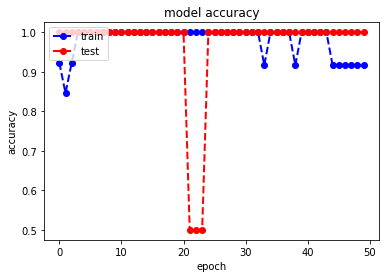

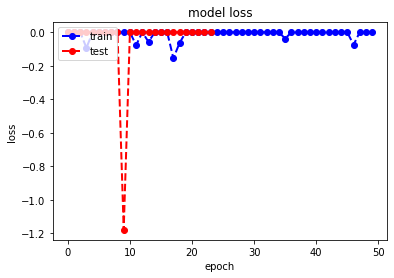

In [ ]:
# Convolutional Neural Network
clf1 = MLPClassifier(solver='adam',
                      hidden_layer_sizes=5,
                      activation='relu',
                      max_iter = 50,
                      verbose=True,
                      tol= 1e-100,
                      n_iter_no_change=1,
                      early_stopping=True,
                      warm_start=True)


# Random Forest
clf2 =  RandomForestClassifier(random_state=1)
estimator = linear_model.LogisticRegression(solver="liblinear", multi_class="ovr")

#http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1 , clf2],
                          meta_classifier=lr)

print('3-fold cross validation:\n')
for clf, label in zip([ clf1, clf2, sclf],
                      ['Convolutional Neural Network', #from sklearn.neural_network import MLPClassifier
                       'Random Forest',
                       'Stacking Classifier']):

    history = clf.fit(X_train, y_train_org)
    scores = model_selection.cross_val_score(clf, X_train, y_train_org,
                                              cv=50, scoring='accuracy') # cv = EPOCH
    scores_test = model_selection.cross_val_score(clf, X_test, y_test_org,
                                              cv=50, scoring='accuracy')

    predictions = clf.predict(X_test[:10])
    target = y_test_org[:10]
    correct = 0
    wrong = 0
    for i in range( len(predictions)):
        if (predictions[i] == target[i]):
            correct += 1
        else:
            wrong += 1
        print(predictions[i] , target[i])


    print('correct:', correct)
    print('wrong:', wrong)

    acc = accuracy_score(target, predictions)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (acc, scores.std(), label))


    plt.plot(scores, color='blue',
         marker='.', linestyle='dashed', linewidth=2, markersize=12)
    plt.plot(scores_test, color='red',
      marker='.', linestyle='dashed', linewidth=2, markersize=12)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    lasso = linear_model.Lasso()
    losss = cross_val_score(lasso,  X_train, y_train_org, cv=50)
    losss_test = cross_val_score(lasso,  X_test, y_test_org, cv=50)
    plt.plot(losss, color='blue',
            marker='.', linestyle='dashed', linewidth=2, markersize=12)
    plt.plot(losss_test, color='red',
        marker='.', linestyle='dashed', linewidth=2, markersize=12)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()